# Name: Daniel Birman
### Date: 08/25/2023

<style>
.jp-Notebook {
    padding: var(--jp-notebook-padding);
    margin-left: 160px;
    outline: none;
    overflow: auto;
    background: var(--jp-layout-color0);
}
</style>

# Setup and Data    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
awards = pd.read_csv("awards_data.csv")
player_data = pd.read_csv("player_stats.csv")
team_data = pd.read_csv("team_stats.csv")
rebounding_data = pd.read_csv("team_rebounding_data_22.csv")

## Part 1 -- Awards  

In this section, I worked with data relating to player awards and statistics. I started with some data manipulation questions and worked towards building a model to predict broad levels of career success.


### Question 1  

**QUESTION:** What is the average number of points per game for players in the 2007-2021 seasons who won All NBA First, Second, and Third teams (**not** the All Defensive Teams), as well as for players who were in the All-Star Game (**not** the rookie all-star game)?


 

In [2]:
def calculate_team_avg(player_data, awards, team_name):
    # Filter player_data for seasons >= 2007
    filtered_data = player_data[player_data['season'] >= 2007]

    # Merge the filtered player_data with the awards DataFrame
    team_data = filtered_data.merge(awards)

    # Filter for players in the specified team
    team_data = team_data[team_data[team_name] == 1]

    # Select only the relevant columns
    team_data = team_data[['nbapersonid', 'player', 'season', 'games', 'points']]

    # Calculate and add the 'avg' column
    team_data['avg'] = team_data['points'] / team_data['games']

    # Calculate the mean of 'avg' and round it to 1 decimal place
    team_avg_pts = round(team_data['avg'].mean(), 1)

    return team_avg_pts

first_avg_pts = calculate_team_avg(player_data, awards, 'All NBA First Team')
print('1st Team: ' + str(first_avg_pts) + ' points per game')

second_avg_pts = calculate_team_avg(player_data, awards, 'All NBA Second Team')
print('2nd Team: ' + str(second_avg_pts) + ' points per game')

third_avg_pts = calculate_team_avg(player_data, awards, 'All NBA Third Team')
print('3rd Team: ' + str(third_avg_pts) + ' points per game')

all_star_avg_pts = calculate_team_avg(player_data, awards, 'all_star_game')
print('All-Star: ' + str(all_star_avg_pts) + ' points per game')

1st Team: 25.9 points per game
2nd Team: 23.1 points per game
3rd Team: 20.5 points per game
All-Star: 21.6 points per game


<strong><span style="color:red">ANSWER 1:</span></strong>   

1st Team: 25.9 points per game  
2nd Team: 23.1 points per game  
3rd Team: 20.5 points per game  
All-Star: 21.6 points per game  

### Question 2  

**QUESTION:** Here I have to find the average number of years of experience in the league it takes for players to make their first All NBA Selection (1st, 2nd, or 3rd team)? I limited my sample to players drafted in 2007 or later who did eventually go on to win at least one All NBA selection. For example:

- Luka Doncic is in the dataset as 2 years. He was drafted in 2018 and won his first All NBA award in 2019 (which was his second season).  
- LeBron James is not in this dataset, as he was drafted prior to 2007.  
- Lu Dort is not in this dataset, as he has not received any All NBA honors.  



In [3]:
# Filter the data for players drafter in 2007 or later
filtered_players = player_data[player_data['draftyear'] >= 2007]

# Merge and select relevant columns
merged_awards_data = (
    filtered_players
    .merge(awards)
    .sort_values(by='player')
    .loc[:, ['nbapersonid', 'player', 'draftyear', 'season', 'All NBA First Team', 'All NBA Second Team', 'All NBA Third Team']]
)

# Filter rows with any All NBA team selection
all_nba_players = merged_awards_data[merged_awards_data[['All NBA First Team', 'All NBA Second Team', 'All NBA Third Team']].any(axis=1)].sort_values(['nbapersonid','season'],  ascending = True)

# Group by player, season, and draftyear, select the first team selection, and calculate years of experience
first_selections_by_player = (
    all_nba_players
    .groupby(['nbapersonid', 'season', 'draftyear'])
    .agg({'All NBA First Team': 'first', 'All NBA Second Team': 'first', 'All NBA Third Team': 'first'})
    .reset_index()
    .drop_duplicates(subset='nbapersonid',keep='first')
)
first_selections_by_player['years_of_experience'] = first_selections_by_player['season'] - first_selections_by_player['draftyear']
first_selections_by_player

# Calculate the average years of experience
average_experience_for_all_nba_players = round(first_selections_by_player['years_of_experience'].mean(), 1)
print(average_experience_for_all_nba_players)

3.7


<strong><span style="color:red">ANSWER 2:</span></strong>  

3.7 Years  

## Data Cleaning Interlude  

I created a dataset with a "career outcome" for each player, representing the highest level of success that the player achieved for at least two seasons after his first four seasons in the league.

- Elite: A player is "Elite" in a season if he won any All NBA award (1st, 2nd, or 3rd team), MVP, or DPOY in that season.    
- All-Star: A player is "All-Star" in a season if he was selected to be an All-Star that season.   
- Starter:  A player is a "Starter" in a season if he started in at least 41 games in the season OR if he played at least 2000 minutes in the season.    
- Rotation:  A player is a "Rotation" player in a season if he played at least 1000 minutes in the season.   
- Roster:  A player is a "Roster" player in a season if he played at least 1 minute for an NBA team but did not meet any of the above criteria.     
- Out of the League: A player is "Out of the League" if he is not in the NBA in that season.   

I adjusted the determination for Starter/Rotation qualifications for the seasons with fewer than 82 games per team. For example, in the 2011 lockout season with 66 possible games, if a player played 900 minutes, it would be considered as 900 * (82/66) = 1118 minutes for qualification. Similarly, for games started, if a player started 38 games in 2019 or 2020 (each with 72 possible games), it would be considered as 38 * (82/72) = 43 games started. All calculations were rounded to the nearest whole number.

I noted that on a season level, a player's outcome is the highest level of success he qualifies for in that season. For example, Shai Gilgeous-Alexander, who was both All-NBA 1st team and an All-Star last year, would be considered "Elite" for the 2022 season. However, for his career outcome, if he were to make one more All-Star game but no more All-NBA teams in the rest of his career, he would be classified as "All-Star." This is a hypothetical scenario, as Shai has not yet played enough to have a career outcome.

Examples:  

- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Rotation (3), Roster (4), Roster (5), Out of the League (6+) would be considered "Out of the League," because after his first four seasons, he only has a single Roster year, which does not qualify him for any success outcome.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), All-Star (7), Elite (8), Starter (9) would be considered "All-Star," because he had at least two seasons after his first four at all-star level of production or higher.  
- A player who enters the league as a rookie and has season outcomes of Roster (1), Rotation (2), Starter (3), Starter (4), Starter (5), Starter (6), Rotation (7), Rotation (8), Roster (9) would be considered a "Starter" because he has two seasons after his first four at a starter level of production. 


### Question 3  

**QUESTION:** There are 73 players in the `player_data` dataset who have 2010 listed as their draft year. How many of those players have a **career** outcome in each of the 6 buckets?  

In [4]:
# Reload or recreate the 'player_data' DataFrame with the original data
player_data_copy = player_data.copy()

# Filter the dataset to select players with draft year 2010
drafts_2010 = player_data_copy[player_data_copy['draftyear'] == 2010].sort_values(['player', 'season'])

# Merge with awards dataset
drafts_2010 = drafts_2010.merge(awards,how='outer')

for index, row in drafts_2010.iterrows():
    if (row['All NBA Defensive First Team'] == 1) or \
       (row['All NBA Defensive Second Team'] == 1) or \
       (row['All NBA First Team'] == 1) or \
       (row['All NBA Second Team'] == 1) or \
       (row['All NBA Third Team'] == 1) or \
       (row['Most Valuable Player_rk'] == 1) or \
       (row['Defensive Player Of The Year_rk'] == 1):
        drafts_2010.at[index, 'Elite'] = 1.0
    if (row['all_star_game'] == 1):
        drafts_2010.at[index, 'All-Star'] = 1.0
        
    if (row['season'] == 2011) and ((row['games'] * (82/66)) >= 41 or (row['mins'] * (82/66)) >= 2000):
        drafts_2010.at[index, 'Starter'] = 1.0
    elif ((row['season'] == 2019 or row['season'] == 2020) and 
    ((row['games'] * (82/72)) >= 41 or (row['mins'] * (82/72)) >= 2000)):
        drafts_2010.at[index, 'Starter'] = 1.0
    elif ((row['season'] != 2011 and row['season'] != 2019 and row['season'] != 2020) and 
    (row['games'] >= 41 or row['mins'] >= 2000)):
        drafts_2010.at[index, 'Starter'] = 1.0
        
    if (row['season'] == 2011) and ((row['mins'] * (82/66)) >= 1000):
        drafts_2010.at[index, 'Rotation'] = 1.0
    elif ((row['season'] == 2019 or row['season'] == 2020) and 
    ((row['mins'] * (82/72)) >= 1000)):
        drafts_2010.at[index, 'Rotation'] = 1.0
    elif ((row['season'] != 2011 and row['season'] != 2019 and row['season'] != 2020) and 
    (row['mins'] >= 1000)):
        drafts_2010.at[index, 'Rotation'] = 1.0

    if row['mins'] >= 1:
        drafts_2010.at[index, 'Roster'] = 1.0
        
counts_df = drafts_2010[['player','season','Elite','All-Star','Starter','Rotation','Roster']].groupby(['player','season']).sum().sort_values(['player','season']).clip(0, 1)
counts_df['Out of the League'] = 0.0
counts_df = counts_df.reset_index()

# Create an empty list to store DataFrames
dfs_to_concat = []

# Create a list of unique players
unique_players = counts_df['player'].unique()

# Iterate over unique players
for player in unique_players:
    player_data_copy = counts_df[counts_df['player'] == player]
    
    # Iterate over seasons for each player
    for i in range(player_data_copy.shape[0] - 1):
        current_row = player_data_copy.iloc[i]
        next_row = player_data_copy.iloc[i + 1]
        
        # Check if there's a gap between seasons
        if next_row['season'] - current_row['season'] > 1:
            # Insert rows for the missing seasons
            for season in range(current_row['season'] + 1, next_row['season']):
                new_row = {
                    'player': player,
                    'season': season,
                    'Elite': 0.0,
                    'All-Star': 0.0,
                    'Starter': 0.0,
                    'Rotation': 0.0,
                    'Roster': 0.0,
                    'Out of the League': 1.0
                }
                dfs_to_concat.append(pd.DataFrame([new_row]))

# Concatenate all DataFrames in the list
if dfs_to_concat:
    counts_df = pd.concat([counts_df] + dfs_to_concat, ignore_index=True)

# Sort the DataFrame by player and season
counts_df = counts_df.sort_values(['player', 'season']).reset_index(drop=True)

#determines players highest level of success for that season
counts_df['season outcome'] = counts_df.apply(lambda row: 'Elite' if row['Elite'] == 1
                                              else 'All-Star' if row['All-Star'] == 1
                                              else 'Starter' if row['Starter'] == 1
                                              else 'Rotation' if row['Rotation'] == 1
                                              else 'Roster' if row['Roster'] == 1
                                              else 'Out of the League', axis=1)

def determine_career_success(career_outcomes):
    if len(career_outcomes) >= 6:  # At least 4 initial seasons + 2 additional seasons
        after_first_four = career_outcomes[4:]
        
        if 'Elite' in after_first_four or 'All-Star' in after_first_four:
            return 'Elite'
        elif 'Starter' in after_first_four:
            return 'Starter'
        elif 'Rotation' in after_first_four:
            return 'Rotation'
    return 'Roster'

# Iterate over unique players to determine career success
for player in unique_players:
    player_data_copy = counts_df[counts_df['player'] == player]
    
    # Check if the player has at least four seasons in the league
    if player_data_copy.shape[0] >= 4:
        # Extract the season outcomes for the player's career
        career_outcomes = player_data_copy['season outcome'].values
        
        # Determine career success using the function
        career_success = determine_career_success(career_outcomes)
    else:
        career_success = 'Out of the League'
    
    # Update the 'career_success' column in the original counts_df
    counts_df.loc[counts_df['player'] == player, 'career_success'] = career_success

# Display the updated counts_df with the 'career_success' column
counts_df = counts_df.groupby(['player','career_success']).count().reset_index()
counts_df['career_success'].value_counts()

Out of the League    32
Starter              21
Roster               13
Elite                 7
Name: career_success, dtype: int64

<strong><span style="color:red">ANSWER 3:</span></strong>  

Elite: 7 players.  
All-Star: 0 players.  
Starter: 21 players.  
Rotation: 0 players.  
Roster: 13 players.  
Out of League: 32 players.  

### Open Ended Modeling Question   

I built a model to predict a player's career outcome based on information up through the first four years of his career.

Notes and specifications for my model:

1. I utilized the data provided in my data sets, ensuring not to bring in any external sources of data. It's important to note that while most of the data goes back to 2007, All-NBA and All-Rookie team voting is only included back to 2011.  

2. I limited the training data to players who were drafted in or before the 2015 season. This decision was made because a player needs to complete three additional seasons after their first four to be considered as having a distinct career outcome for our dataset. Since the dataset in this project ends in 2021, this means that a player would need to have had the chance to play in the '21, '20, and '19 seasons after his first four years, and thus his first four years would have been '18, '17, '16, and '15. Karl-Anthony Towns was the #1 pick in that season. 

4. Once I built my model, I predicted on all players who were drafted in 2018-2021 (They have between 1 and 4 seasons of data available and have not yet started accumulating seasons that inform their career outcome).  

5. I later predicted the probability that each player falls into each outcome bucket.    

6. I included a short summary detailing:
  - A brief written overview of how my model works, targeted towards a decision maker in the front office without a strong statistical background. 
  - What I view as the strengths and weaknesses of my model.  
  - How I'd address the weaknesses if I had more time and or more data.  
  - A matplotlib or plotly visualization highlighting some part of the modeling process, the model itself, or my results.  
  - My predictions for Shai Gilgeous-Alexander, Zion Williamson, James Wiseman, and Josh Giddey.

In [5]:
# makes a copy of player_data df
player_data_copy = player_data.copy()

filtered_data = player_data.loc[(player_data['draftyear'] <= 2015) & (player_data['season'] >= 2011)]
filtered_data = filtered_data.merge(awards)

for index, row in filtered_data.iterrows():
    if (row['All NBA Defensive First Team'] == 1) or \
       (row['All NBA Defensive Second Team'] == 1) or \
       (row['All NBA First Team'] == 1) or \
       (row['All NBA Second Team'] == 1) or \
       (row['All NBA Third Team'] == 1) or \
       (row['Most Valuable Player_rk'] == 1) or \
       (row['Defensive Player Of The Year_rk'] == 1):
        filtered_data.at[index, 'Elite'] = 1.0
    if (row['all_star_game'] == 1):
        filtered_data.at[index, 'All-Star'] = 1.0
        
    if (row['season'] == 2011) and ((row['games'] * (82/66)) >= 41 or (row['mins'] * (82/66)) >= 2000):
        filtered_data.at[index, 'Starter'] = 1.0
    elif ((row['season'] == 2019 or row['season'] == 2020) and 
    ((row['games'] * (82/72)) >= 41 or (row['mins'] * (82/72)) >= 2000)):
        filtered_data.at[index, 'Starter'] = 1.0
    elif ((row['season'] != 2011 and row['season'] != 2019 and row['season'] != 2020) and 
    (row['games'] >= 41 or row['mins'] >= 2000)):
        filtered_data.at[index, 'Starter'] = 1.0
        
    if (row['season'] == 2011) and ((row['mins'] * (82/66)) >= 1000):
        filtered_data.at[index, 'Rotation'] = 1.0
    elif ((row['season'] == 2019 or row['season'] == 2020) and 
    ((row['mins'] * (82/72)) >= 1000)):
        filtered_data.at[index, 'Rotation'] = 1.0
    elif ((row['season'] != 2011 and row['season'] != 2019 and row['season'] != 2020) and 
    (row['mins'] >= 1000)):
        filtered_data.at[index, 'Rotation'] = 1.0

    if row['mins'] >= 1:
        filtered_data.at[index, 'Roster'] = 1.0

#determines players highest level of success for that season
filtered_data['season outcome'] = filtered_data.apply(lambda row: 'Elite' if row['Elite'] == 1
                                              else 'All-Star' if row['All-Star'] == 1
                                              else 'Starter' if row['Starter'] == 1
                                              else 'Rotation' if row['Rotation'] == 1
                                              else 'Roster' if row['Roster'] == 1
                                              else 'Out of the League', axis=1)

player_data_copy = filtered_data.copy()
career_outcomes = {}

# Iterate through each player's data
for player_name, player_group in player_data_copy.groupby('player'):
    # Sort the player's data by season
    player_group = player_group.sort_values(by='season')
    
    # Check if the player has at least four seasons of data
    if len(player_group) >= 4:
        # Check the highest level of success for the first four seasons
        first_four_seasons = player_group.head(4)['season outcome'].tolist()
        
        # Check the subsequent seasons (after the first four)
        subsequent_seasons = player_group.tail(len(player_group) - 4)['season outcome'].tolist()
        
        # Combine the two lists and find the unique highest outcomes
        combined_outcomes = first_four_seasons + subsequent_seasons
        unique_outcomes = set(combined_outcomes)
        
        # Determine the career outcome as the highest level achieved for at least two seasons
        for outcome in unique_outcomes:
            if combined_outcomes.count(outcome) >= 2:
                career_outcome = outcome
                break
        else:
            career_outcome = "Out of the League"
    else:
        career_outcome = "Out of the League"
    
    # Store the career outcome for this player
    career_outcomes[player_name] = career_outcome

# Create a DataFrame to store career outcomes
career_outcomes_df = pd.DataFrame(list(career_outcomes.items()), columns=['player', 'career outcome'])

# Merge the career outcomes DataFrame with the original data
filtered_data_with_career = filtered_data.merge(career_outcomes_df, on='player')

# Display the DataFrame with career outcomes
career_outcomes = filtered_data_with_career[['player','season','points','mins','career outcome']].sort_values(['player','season'])
career_outcomes

# Create dictionaries to store career points and career minutes for each player
career_points = {}
career_minutes = {}

# Iterate through each player's data
for player_name, player_group in filtered_data_with_career.groupby('player'):
    # Calculate the career points by summing points scored in each season
    career_points[player_name] = player_group['points'].sum()
    
    # Calculate the career minutes by summing minutes played in each season
    career_minutes[player_name] = player_group['mins'].sum()

# Create DataFrames to store career points and career minutes
career_points_df = pd.DataFrame(list(career_points.items()), columns=['player', 'career points'])
career_minutes_df = pd.DataFrame(list(career_minutes.items()), columns=['player', 'career minutes'])

# Merge the career points and career minutes DataFrames with the original data
filtered_data_with_career_stats = filtered_data_with_career.merge(career_points_df, on='player')
filtered_data_with_career_stats = filtered_data_with_career_stats.merge(career_minutes_df, on='player')

# Display the DataFrame with career points and career minutes
career_stats_df = filtered_data_with_career_stats[['player', 'career points', 'career minutes','career outcome']]
career_stats_df = career_stats_df.groupby(['player', 'career points', 'career minutes','career outcome']).count().reset_index()
career_stats_df

,player,career points,career minutes,career outcome
0,Aaron Brooks,1351,2968,Out of the League
1,Aaron Gordon,6168,13414,Roster
2,Adreian Payne,84,178,Out of the League
3,Al Harrington,910,1761,Out of the League
4,Al Horford,8395,18960,All-Star
...,...,...,...,...
504,Wilson Chandler,2365,6454,Roster
505,Xavier Munford,3,21,Out of the League
506,Zach LaVine,9466,15219,All-Star
507,Zach Randolph,5893,11645,Starter


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Encode the career outcomes into numerical labels
label_encoder = LabelEncoder()
career_stats_df['career outcome encoded'] = label_encoder.fit_transform(career_stats_df['career outcome'])

# Extract the features (career points and career minutes) and the encoded target
X = career_stats_df[['career points', 'career minutes']]
y = career_stats_df['career outcome encoded']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a logistic regression classifier
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the logistic regression model: {accuracy * 100:.2f}%")

# Function to predict career outcome for a single season
def predict_career_outcome(career_points, career_minutes):
    # Create a DataFrame with the input data
    player_data = pd.DataFrame({
        'career points': [career_points],
        'career minutes': [career_minutes]
    })

    # Make a prediction using the trained logistic regression model
    predicted_outcome_encoded = model.predict(player_data[['career points', 'career minutes']])
    predicted_outcome = label_encoder.inverse_transform(predicted_outcome_encoded)

    return predicted_outcome[0]

Accuracy of the logistic regression model: 65.69%


### Modeling Reflection:

1 - My career outcome prediction model utilizes historical basketball player data, focusing on career points and career minutes, to make data-driven predictions about a player's future career outcome. This tool employs a machine learning technique called Logistic Regression to analyze how these statistics relate to career success, quantifying outcomes into numerical labels for understanding. After  training and validation, it can provide valuable insights to inform player recruitment, contract decisions, and team strategy, ultimately aiding in more informed and strategic choices for the team's success.

2 - A strength of my model is it's simple yet effective model that uses linear regression to predict a players career outcome. Linear Regression serves as a good starting point for modeling, providing a baseline to compare against more complex models. A weakness I believe is that the model only looks at a players rookie year, so if a player is just getting adjusted to the league he may not score as much points, rendering him in a lower bracket. Also, another weakness is that the model only takes into account the relationship between minutes played and points scored, and doesnt take into account things like awards or recognitions a player might receive making them more apt of being place in a higher category.

3 - I would adress this weaknesses by not limiting the model to a players rookie season, as points scored in their first season may not be indicitive of their career success. Also, I would focus my next model on taking into consideration awards that a player receives which may increase their category.

<Axes: xlabel='career minutes', ylabel='career points'>

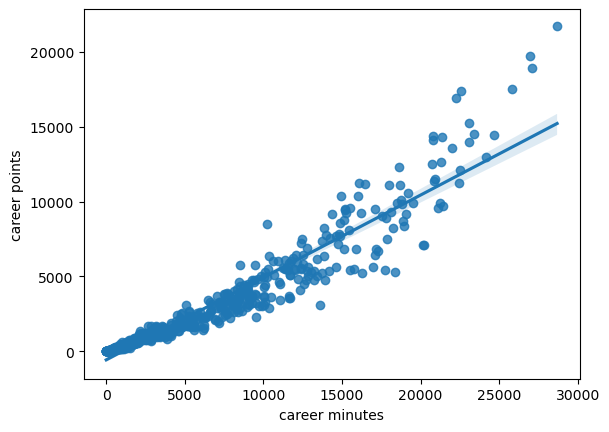

In [7]:
reg = np.polyfit(career_stats_df['career minutes'],career_stats_df['career points'],deg=1)
trend = np.polyval(reg,career_stats_df['career minutes'])
sb.regplot(x='career minutes',y='career points',fit_reg=True,data=career_stats_df)

In [8]:
# Predict the career outcome for the player based on the single season's statistics
shai_points = player_data.loc[player_data['player'] == 'Shai Gilgeous-Alexander','points'].values[0]
shai_mins = player_data.loc[player_data['player'] == 'Shai Gilgeous-Alexander','mins'].values[0]
shai_gilgeous_alexander_predict = predict_career_outcome(shai_points, shai_mins)

zion_points = player_data.loc[player_data['player'] == 'Zion Williamson','points'].values[0]
zion_mins = player_data.loc[player_data['player'] == 'Zion Williamson','mins'].values[0]
zion_williamson_predict = predict_career_outcome(zion_points, zion_mins)

wiseman_points = player_data.loc[player_data['player'] == 'James Wiseman','points'].values[0]
wiseman_mins = player_data.loc[player_data['player'] == 'James Wiseman','mins'].values[0]
james_wiseman_predict = predict_career_outcome(wiseman_points, wiseman_mins)

wiseman_points = player_data.loc[player_data['player'] == 'James Wiseman','points'].values[0]
wiseman_mins = player_data.loc[player_data['player'] == 'James Wiseman','mins'].values[0]
james_wiseman_predict = predict_career_outcome(wiseman_points, wiseman_mins)

giddey_points = player_data.loc[player_data['player'] == 'Josh Giddey','points'].values[0]
giddey_mins = player_data.loc[player_data['player'] == 'Josh Giddey','mins'].values[0]
josh_giddey_predict = predict_career_outcome(giddey_points, giddey_mins)

print('Shai Gilgeous-Alexander Predicted Career Outcome: ' + shai_gilgeous_alexander_predict)
print('Zion Williamson Career Outcome: ' + zion_williamson_predict)
print('James Wiseman Career Outcome: ' + james_wiseman_predict)
print('Josh Giddey Career Outcome: ' + josh_giddey_predict)

Shai Gilgeous-Alexander Predicted Career Outcome: Out of the League
Zion Williamson Career Outcome: Out of the League
James Wiseman Career Outcome: Out of the League
Josh Giddey Career Outcome: Out of the League


## Part 2 -- Predicting Team Stats  

 
### Question 1   

Using the `rebounding_data` dataset, I predicted a team's next game's offensive rebounding percent to be their average offensive rebounding percent in all prior games. On a single game level, offensive rebounding percent is the number of offensive rebounds divided by their number offensive rebound "chances" (essentially the team's missed shots). On a multi-game sample, it should be the total number of offensive rebounds divided by the total number of offensive rebound chances.    

Next I calculated what OKC's predicted offensive rebound percent is for game 81 in the data. That is, I used games 1-80 to predict game 81.  

In [9]:
only_okc = rebounding_data.loc[rebounding_data['team'] == 'OKC']
only_okc = only_okc.reset_index().drop('index',axis=1).iloc[:80]
print(round((only_okc['offensive_rebounds'].sum() / only_okc['off_rebound_chances'].sum()) * 100,1))

28.9


<strong><span style="color:red">ANSWER 1:</span></strong>  

28.9% 

### Question 2  

There are a few limitations to the method I used above. For example, if a team has a great offensive rebounder who has played in most games this season but will be out due to an injury for the next game, I might reasonably predict a lower team offensive rebound percent for the next game.  

I noted how I thought about changing my original model to better account for missing players.

<strong><span style="color:red">ANSWER 2:</span></strong>  
I think a better way to account for missing players would be to incorporate player-specific data into the model. By incorporating a players game performance stats into the model, I could better predict their contribution or "weight" that they bring to rebound percentage. Thus, if a high % rebounding player is out for a game, our new model could raise or lower the expected rebound %.

### Question 3  

Here I wrote about about a few other potential weaknesses of the simple average model I made in question 1 and discussed how I would deal with each of them.


<strong><span style="color:red">ANSWER 3:</span></strong>  
Weakness 1: Matchups - the model currently treats every game the same, so it does not take into account the team matchups. If the OKC were to play a team with a better win/loss record ("better team"), OKC's rebound % might be lower. So, without taking into consideration the matchups per game, the model might not accurately predict the next games rebound % if OKC is playing a better team.

Solution 1: Incorporate the oppopent team's W-L record into the data set, and use this as a factor if OKC may perform better or worse for their rebound %.

Weakness 2: Variability - the current model has the weight of each game the same regardless of previous context. Certain game circustances that may have an effect on the rebound percentage (home court advantage, current player performance) are not currently taken into consideration for this model.

Solution 2: By incorporating game circumstances like home court advantage, player performance trends, etc., the new model will have a better way of prediciting the rebound % based on these factors since not every game will be weighted equally.

Weakness 3: Roster - the current model doesn't take into consideration which players played in a specific game, so it can be hard to tell why a rebound % was much higher or lower than expected for that game.

Solution 3: Adding the players that played in that game and their current performance can help the model because if certain players are underperforming, the model can take their data into consideration, rather than acting as if the same players with the same stats played in every game.